In [1]:
from pathlib import Path, PurePath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.util.attribdict import AttribDict
from preprocessing_tools import *

1 día de datos, primeros 4 dígitos estación, y luego el canal después del punto. Hay un evento significativo de magnitud mayor a 5 que puede usarse como referencia para probar la buena implementación del método de John Ebel y Nawa Dahal.

El archivo catalog.dat sirve para especificar los eventos sísmicos significativos que fueron detectados en el conjunto grande de datos y sus columnas son: fecha, hora, latitud, longitud, profundidad, magnitud y lasa ultimas tres columnas son datos independientes relacionados con la similitud o correlación entre dichos eventos. A partir de este archivo, es posible localizar y filtrar los datos completos para incluir únicamente la sección en que se percibieron estos eventos para tratar menos datos. Posibilidad de paralelizar en caso de que se requiera.

Una vez hecho esto, ya toca implementar el método de John Ebel y Nawa Dahal en cuestión

In [2]:
directorio_sub = r'Datos/'
directorioSSN_Oaxaca = r'Datos_SSN_Oaxaca/'
directorioSSN_Guerrero = r'Datos_SSN_Guerrero/'
dir_rec_name = r'Datos_Trim/'


directorio_completo = directorioSSN_Oaxaca
directorio_recortado = dir_rec_name
if not os.path.exists(directorio_recortado):
    os.makedirs(directorio_recortado)

In [3]:
catalog_sub = 'catalog.dat'
catalogSSN_Oaxaca = 'catalogSSN_Oaxaca.dat'
catalogSSN_Guerrero = 'catalogSSN_Guerrero.dat'

catalog = catalogSSN_Oaxaca

In [4]:
df_catalog = read_catalog(catalog)

El catálogo servirá para especificar cuáles son los eventos a procesar, ignorando el resto de eventos que posiblemente ya estén presentes dentro del directorio.

Si hay eventos dentro del catálogo que ya habían sido procesados y que por lo tanto ya estaban presentes dentro del directorio, estos se eliminan previamente para repetir el procesamiento.

In [5]:
for i, row in df_catalog.iterrows():
    path = Path(directorio_recortado+row.date_time_id)
    if path.exists():
        shutil.rmtree(path)

In [6]:
df_catalog.head()

,date_time,lat,lon,depth,mag,corr,date_time_id
0,2016-06-27T20:50:35.000000Z,16.21,-98.0,21.3,5.2,"[0.9316, 51.61, 20160627205035.0]",2016.06.27.20.50.35


In [7]:
df_sort = df_catalog.sort_values('mag', ascending=False).copy()

In [8]:
df_sort.head()

,date_time,lat,lon,depth,mag,corr,date_time_id
0,2016-06-27T20:50:35.000000Z,16.21,-98.0,21.3,5.2,"[0.9316, 51.61, 20160627205035.0]",2016.06.27.20.50.35


In [9]:
t0 = df_sort['date_time'][0] # tiempo de sismo mas fuerte registrado
tf = t0 + 60
print(t0)

2016-06-27T20:50:35.000000Z


In [10]:
stations_meta = get_meta_data(directorio_completo)

In [11]:
stations_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b       12 non-null     float64
 1   cmpaz   12 non-null     float64
 2   cmpinc  12 non-null     float64
 3   delta   12 non-null     float64
 4   depmax  12 non-null     float64
 5   depmen  12 non-null     float64
 6   depmin  12 non-null     float64
 7   e       12 non-null     float64
 8   idep    12 non-null     int64  
 9   iftype  12 non-null     int64  
 10  istreg  12 non-null     int64  
 11  kcmpnm  12 non-null     object 
 12  kevnm   12 non-null     object 
 13  kinst   12 non-null     object 
 14  knetwk  12 non-null     object 
 15  kstnm   12 non-null     object 
 16  lcalda  12 non-null     int64  
 17  leven   12 non-null     int64  
 18  lovrok  12 non-null     int64  
 19  lpspol  12 non-null     int64  
 20  npts    12 non-null     int64  
 21  nvhdr   12 non-null     int64  
 22  nzho

In [12]:
stations_meta['kstnm']

0     CAIG
1     CAIG
2     CAIG
3     HUIG
4     HUIG
5     HUIG
6     OXIG
7     OXIG
8     OXIG
9     PNIG
10    PNIG
11    PNIG
Name: kstnm, dtype: object

In [13]:
stations_meta.head(30) # stel dejar tal cual o a 0
# No unir en grupos las filas ya que las primeras columnas son de orientacion de los sensores de cada canal, lo cual es importante
# Crear repositorio github

,b,cmpaz,cmpinc,delta,depmax,depmen,depmin,e,idep,iftype,...,nzjday,nzmin,nzmsec,nzsec,nzyear,o,stdp,stel,stla,stlo
0,0.0,90.0,90.0,0.01,151526.0,-115.870369,-94973.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,40.0,17.048500,-100.267303
1,0.0,0.0,90.0,0.01,290656.0,1412.713501,-154193.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,40.0,17.048500,-100.267303
2,0.0,90.0,0.0,0.01,194153.0,1111.765503,-166316.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,40.0,17.048500,-100.267303
3,0.0,90.0,90.0,0.01,768309.0,-856.964111,-535328.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,130.0,15.769200,-96.108299
4,0.0,0.0,90.0,0.01,920392.0,644.857605,-681551.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,130.0,15.769200,-96.108299
5,0.0,90.0,0.0,0.01,542099.0,390.864075,-505177.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,130.0,15.769200,-96.108299
6,0.0,90.0,90.0,0.01,4624000.0,772.998718,-3646623.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,1737.0,17.072599,-96.733002
7,0.0,0.0,90.0,0.01,2207032.0,937.799438,-1878835.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,1737.0,17.072599,-96.733002
8,0.0,90.0,0.0,0.01,1853949.0,675.616821,-2062230.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,1737.0,17.072599,-96.733002
9,0.0,90.0,90.0,0.01,10522011.0,835.762085,-10378819.0,300.0,8,1,...,179,50,0,35,2016,0.0,0.0,273.0,16.392799,-98.127403


In [14]:
stations_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b       12 non-null     float64
 1   cmpaz   12 non-null     float64
 2   cmpinc  12 non-null     float64
 3   delta   12 non-null     float64
 4   depmax  12 non-null     float64
 5   depmen  12 non-null     float64
 6   depmin  12 non-null     float64
 7   e       12 non-null     float64
 8   idep    12 non-null     int64  
 9   iftype  12 non-null     int64  
 10  istreg  12 non-null     int64  
 11  kcmpnm  12 non-null     object 
 12  kevnm   12 non-null     object 
 13  kinst   12 non-null     object 
 14  knetwk  12 non-null     object 
 15  kstnm   12 non-null     object 
 16  lcalda  12 non-null     int64  
 17  leven   12 non-null     int64  
 18  lovrok  12 non-null     int64  
 19  lpspol  12 non-null     int64  
 20  npts    12 non-null     int64  
 21  nvhdr   12 non-null     int64  
 22  nzho

In [15]:
stations_meta.loc[stations_meta['kstnm'] == 'TLIG']

,b,cmpaz,cmpinc,delta,depmax,depmen,depmin,e,idep,iftype,...,nzjday,nzmin,nzmsec,nzsec,nzyear,o,stdp,stel,stla,stlo


In [16]:
Trim_Org(directorio_recortado, directorio_completo, 150, df_catalog, stations_meta)

No hay que hacer group by ya que cada canal de cada estacion tiene ciertas alineaciones o angulos distintos

Descuidar de altitudes negativas, estblecer en 0 si se da error

In [17]:
stations_meta[['kstnm', 'kcmpnm']].head(20)

,kstnm,kcmpnm
0,CAIG,HHE
1,CAIG,HHN
2,CAIG,HHZ
3,HUIG,HHE
4,HUIG,HHN
5,HUIG,HHZ
6,OXIG,HHE
7,OXIG,HHN
8,OXIG,HHZ
9,PNIG,HHE


In [18]:
ev_st_df = link_ev_st(directorio_recortado)

In [19]:
ev_st_df.head(50)

,starttime,endtime,sampling_rate,st,ch,date_time_id
0,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,HUIG,HHZ,2016.06.27.20.50.35
1,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,OXIG,HHN,2016.06.27.20.50.35
2,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,OXIG,HHE,2016.06.27.20.50.35
3,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,HUIG,HHE,2016.06.27.20.50.35
4,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,PNIG,HHZ,2016.06.27.20.50.35
5,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,CAIG,HHN,2016.06.27.20.50.35
6,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,HUIG,HHN,2016.06.27.20.50.35
7,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,PNIG,HHN,2016.06.27.20.50.35
8,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,CAIG,HHZ,2016.06.27.20.50.35
9,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,PNIG,HHE,2016.06.27.20.50.35


In [20]:
ev_st_df.index

RangeIndex(start=0, stop=24, step=1)

In [21]:
#stations_meta.loc[stations_meta['kstnm'] == '1S01'].iloc[1]

In [22]:
#A = obspy.read('Datos_Trim/*')

#A.plot()
#plt.show()

En desarrollo...

In [23]:
year=float(df_catalog['date_time'][0].year)
year

2016.0

In [24]:
remove_response = True
# archivo de configuracion con variables
invs = {}
directorio = 'Respuesta_Instrumento/'
if remove_response:
    net='IG'
    for sta in stations_meta['kstnm'].unique():
        for file in os.listdir(directorio):
            #print(file)
            #print(file.split('_')[2][:4])
            year_before=float(file.split('_')[2][:4])
            year_after=float(file.split('_')[3][:4])
            if re.match('%s_%s_\d+_\d+.*\.RESP'%(sta, net), file) and year_before < year and year_after > year: # Para que solo lea las respuestas de instrumentos actuales
                with open(directorio+file) as f:
                    invs[sta] = obspy.read_inventory(f)

# Se dan ciertos errores al usar este objeto
#inventory = obspy.core.inventory.Inventory(sum([inv.networks for inv in list(invs.values())], [])) # Concatena todos los inventarios para unificarlos en uno solo

In [25]:
rotate_zne = False
#distances = []
#azimuths = []
#b_azimuths = []
ev_st_df['distance'] = np.nan
ev_st_df['azimuth'] = np.nan
ev_st_df['b_azimuth'] = np.nan

for index, row in df_catalog.iterrows(): # Para todo evento
    event_dir = directorio_recortado + datetime_to_dotformat(row.date_time)+'/'
    outdir = "%sRT"%event_dir # Output directory
    
    st = obspy.read(event_dir+'*', format='SAC')
    
    Path(outdir).mkdir(parents=True,exist_ok=True)
    
    # Remover tendencias de los datos (ej. desfasamientos para alinearse verticalmente con 0 la senal)
    # En el caso de la red submarina no es necesario el paso de quitar la respuesta del instrumento
    st.detrend(type="linear")
    if remove_response:
        for i, sta in stations_meta.iterrows():
            st[i].remove_response(inventory=invs[sta.kstnm], output="DISP",zero_mean=True, plot=False, taper=True)
    st.detrend(type="linear")
    st.detrend(type="demean")

    # Define SAC headers and calculate back-azimtuh for rotation
    origin_time = row.date_time
    depth = row.depth*1000

    #o = []
    #b = []
    for i, sta in stations_meta.iterrows(): # Para todo evento y para toda estacion
        # Se asume que el orden de st es el mismo que el de stations_meta en cuanto a estaciones/canales
        
        #meta = inv.get_channel_metadata(tr.id)
        dist, az, baz = gps2dist_azimuth(row.lat,row.lon,sta.stla,sta.stlo) # dist en metros
        #omarker = origin_time - tr.starttime
        omarker = 0
        # Por como son partidos los datos de cada estacion iniciando exactamente en el mismo tiempo que aquel registrado para el evento dentro del catalogo
        # origin_time y starttime son iguales
        
        # baz (back azimuth) es aquel angulo de la estacion con las coordenadas del sismo o evento, asi que lo tendremos que guardar en el trace 

        # Obspy trace headers
        #tr.stats.coordinates = {'latitude':meta['latitude'], 'longitude':meta['longitude']}
        
        q = f"(date_time_id == '{row.date_time_id}') & (st == '{sta.kstnm}')"
        ix = ev_st_df.query(q).index
        cols = ev_st_df.columns
        
        ev_st_df.iloc[ix, cols.get_loc('distance')] = dist/1000 # A kilometros
        ev_st_df.iloc[ix, cols.get_loc('azimuth')] = az
        ev_st_df.iloc[ix, cols.get_loc('b_azimuth')] = baz
        
        #o.append(0)
        #b.append(-1*omarker)
        
        
        # Hay que guardar otros atributos como starttime y endtime porque al guardar se borran los datos anteriores
        st[i].stats.back_azimuth = baz
        st[i].stats.distance = dist # En metros
        #st[i].stats.starttime = row.date_time
        #st[i].stats.endtime = row
        
        # Solo los datos guardados sobre el atributo sac quedaran grabados en el archivo SAC
        #st[i].stats.sac.az = az
        sacd = AttribDict()
        sacd.stla = sta.stla
        sacd.stlo = sta.stlo
        sacd.stel = sta.stel
        sacd.evla = row.lat
        sacd.evlo = row.lon
        sacd.evdp = depth # in meters
        sacd.az = az
        sacd.baz = baz
        sacd.dist = dist/1000 # A kilometros
        sacd.o = 0
        sacd.b = -1*omarker
        st[i].stats.sac = sacd
        
    #for sta in stations_meta['kstnm'].unique():
    #    traces = st.select(station=sta)
    #    traces.rotate(method="NE->RT")
    
    # No es necesario rotar a ZNE en el caso de los datos de la red submarina ya que los tres componentes o canales ya vienen orientados en norte, este y la vertical
    if rotate_zne:
        # Los canales del SSN ya estan orientados en ZNE
        # Forzosamente se requiere proporcionar un Stream con los tres canales en conjunto a rotar, a diferencia de remove_response
        st_sta = obspy.Stream()
        rotated_sts = []
        for i, sta in stations_meta.iterrows():
            if i%3 == 0:
                if i != 0:
                    #print(st_sta)
                    #print(invs[sta.kstnm])
                    st_sta._rotate_to_zne(invs[sta.kstnm],components=("ZNE","Z12"))
                    rotated_sts.append(st_sta)
                st_sta = obspy.Stream()
            st_sta.append(st[i])
        st = obspy.Stream(sum(rotated_sts, [])) # Unificar en un solo stream y sustituir
    
    # Todas las estaciones submarinas ya vienen con tres componentes, asi que tampoco es necesario verificarlo
    # Se rota a RT para trabajar mas facilmente la distancia y el angulo con cada sismo
    st.rotate(method="NE->RT")
    
    for tr in st:
        tr.write("%s/%s"%(outdir,tr.id),format="SAC")
    
#ev_st_df['distance'] = distances
#ev_st_df['azimuth'] = azimuths
#ev_st_df['b_azimuth'] = b_azimuths

ev_st_df.to_csv('ev_st.csv')

#tr_df['o'] = o
#tr_df['b'] = b

In [26]:
ev_st_df.head()

,starttime,endtime,sampling_rate,st,ch,date_time_id,distance,azimuth,b_azimuth
0,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,HUIG,HHZ,2016.06.27.20.50.35,208.278592,103.282428,283.803569
1,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,OXIG,HHN,2016.06.27.20.50.35,165.479314,54.589652,234.952518
2,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,OXIG,HHE,2016.06.27.20.50.35,165.479314,54.589652,234.952518
3,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,HUIG,HHE,2016.06.27.20.50.35,208.278592,103.282428,283.803569
4,2016-06-27T20:50:35.000000Z,2016-06-27T20:53:05.000000Z,100.0,PNIG,HHZ,2016.06.27.20.50.35,24.384449,326.073712,146.037951


In [27]:
evid_Guerrero = '2016.07.19.13.42.46'
evid_Oaxaca = '2016.06.27.20.50.35'

st = obspy.read(directorio_recortado+evid_Oaxaca+'/RT/*')

In [28]:
print(st[0].stats.sac)

AttribDict({'delta': 0.0099999998, 'depmin': -0.00011560584, 'depmax': 6.2663559e-05, 'b': 0.0, 'e': 150.0, 'o': 0.0, 'stla': 17.0485, 'stlo': -100.2673, 'stel': 40.0, 'evla': 16.209999, 'evlo': -98.0, 'evdp': 21300.0, 'dist': 259.08835, 'az': 291.30817, 'baz': 110.65923, 'depmen': 0.0, 'nzyear': 2016, 'nzjday': 179, 'nzhour': 20, 'nzmin': 50, 'nzsec': 35, 'nzmsec': 0, 'nvhdr': 6, 'npts': 15001, 'iftype': 1, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'kstnm': 'CAIG', 'kcmpnm': 'HHR', 'knetwk': 'IG'})


In [29]:
st[0].data

array([  8.70659846e-07,   8.70547183e-07,   8.70262795e-07, ...,
         5.80382277e-07,   5.82514929e-07,   5.80844073e-07], dtype=float32)

Podria ser que ya vengan filtrados los datos

In [30]:
st[0].stats.starttime

2016-06-27T20:50:35.000000Z

/home/jorge/anaconda3/envs/mecanismos_focales/lib/python3.8/site-packages/obspy-1.2.2-py3.8-linux-x86_64.egg/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/jorge/anaconda3/envs/mecanismos_focales/lib/python3.8/site-packages/obspy-1.2.2-py3.8-linux-x86_64.egg/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


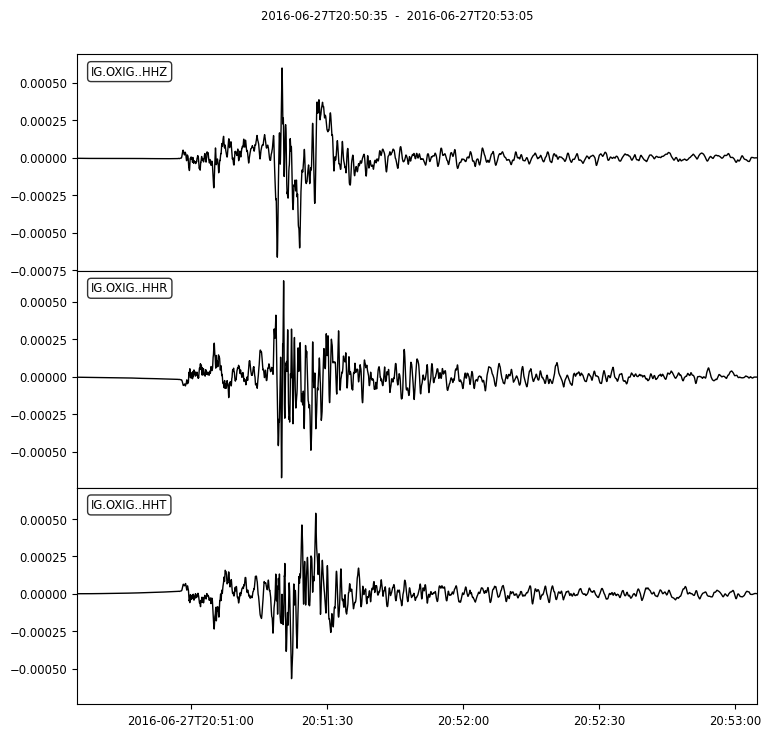

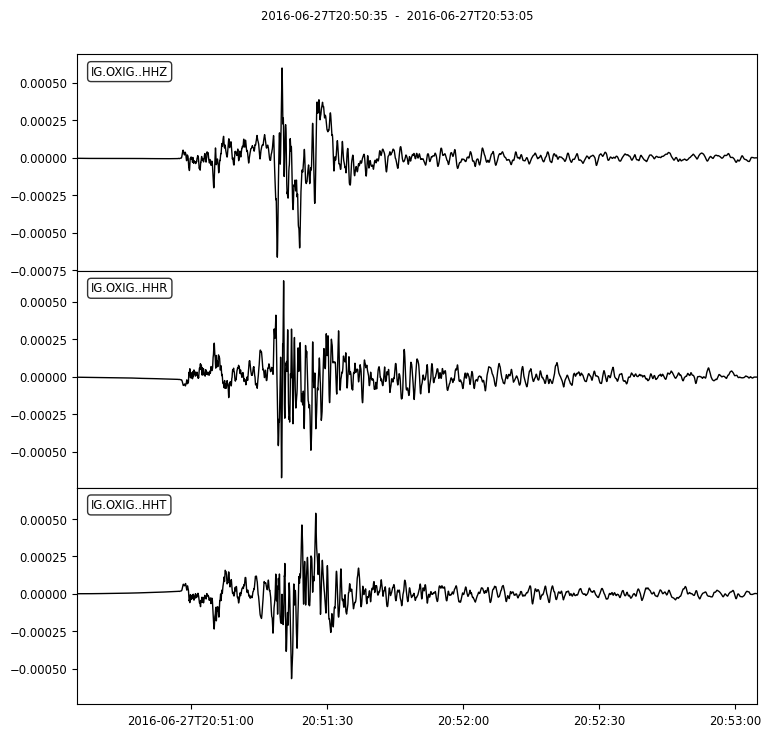

In [31]:
st[6:9].plot()

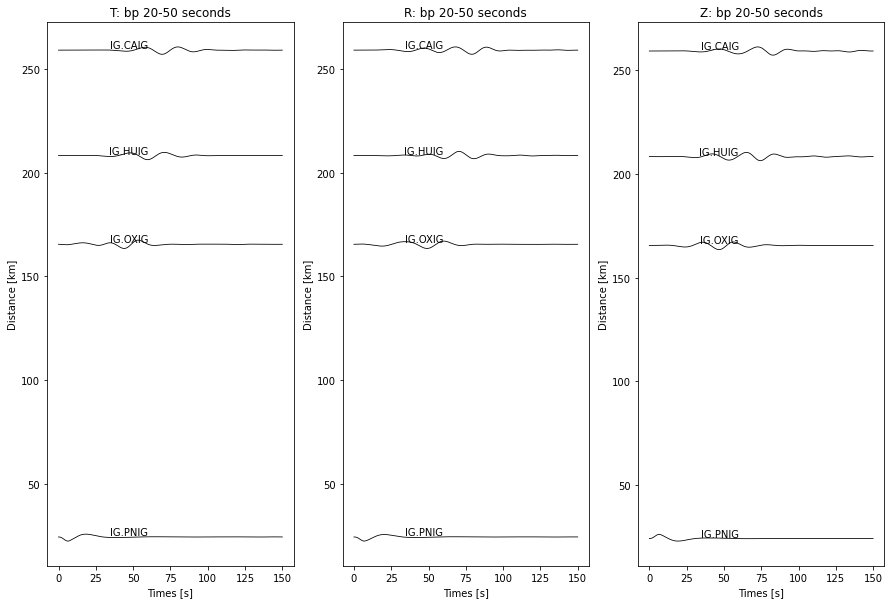

In [32]:
freqmin = 0.02
freqmax = 0.05

# Rango de frecuencias establecido por Dahal y Ebel
#freqmin = 1.5
#freqmax = 2.5

corners = 2
st_filt = st.copy()

st_filt.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)
st_filt.taper(max_percentage=0.05)

xmin = 0
xmax = 60 # El tiempo de grabacion
ymin = 25
ymax = 70
scale = 2
fig, axes = plt.subplots(1,3,figsize=(15,10))
components_sub = ("T","R","U")
components_SSN = ("T","R","Z")
for component, ax in zip(components_SSN,axes):
    for tr in st_filt.select(component=component):
        times = tr.times()
        tr.data /= max(abs(tr.data))
        tr.data *= scale
        ax.plot(times,tr.data+tr.stats.sac.dist,color="black",linewidth=0.8)
        ax.text(xmax,tr.stats.sac.dist,"%s.%s"%(tr.stats.network,tr.stats.station),va="bottom",ha="right")
    #ax.set_xlim(xmin,xmax)
    #ax.set_ylim(ymin,ymax)
    ax.set_xlabel("Times [s]")
    ax.set_ylabel("Distance [km]")
    ax.set_title("%s: bp %.0f-%.0f seconds"%(component,1/freqmax,1/freqmin))

# Sección Pruebas

## Continuar con el resto de pasos para el cálculo de mecanismos ahora que ya se ha incorporado al flujo de preprocesamiento los datos del SSN

Problema con calculo de distancias ya que la amplitud no es consistente? 

Comparar con los sismogramas del SSN para el sismo de mayor magnitud (5.2) para averiguar diferencia o potencial pre filtrado y continuar con calculo de mecanismos focales

Usar el programa compartido para descargar con los comandos compartidos en DropBox. Ver video sobre respuesta de instrumentación

Hacer primero para estaciones de Tierra removiendo repuesta del instrumento

Todo esto para validar el método y descubrir posible influencia de prefiltrado

In [30]:
sismo_SSN = obspy.read('Datos_SSN/*.sac')

Exception: No file matching file pattern: Datos_SSN/*.sac

In [ ]:
sismo_SSN[0].stats

Como estas estaciones no están orientadas en componentes N, E y U, sería necesario obtener el inventario de estaciones para poder usar las funcionees de Obspy para la rotación a los componentes R, T y U.

Pero en cuanto a quitar la respuesta del instrumento, quizá no sea necesario el inventario, simplemente se tratará de una serie de filtrados de frecuencia de acuerdo a los registros de variación de amplitud respecto a la frecuencia. Se quiere usar el rango de frecuencias que muestre una tendencia de amplitud lo más horizontal posible para cada estación. En la carpeta de respuestas para las estaciones del SSN a trabajar, los archivos tienen en su nombre un año que indica en qué momento dejó de usarse el sensor, así que solo debe usarse la primera respuesta que indique una fecha posterior a 2018, ya que estos habrán estado en uso durante el tiempo de estudio de este sismo de mayor magnitud. Fechas posteriores a la primera respuesta posterior a 2018 no registraron la señal del sismo de interés ya que fueron usados años más tarde

Una vez que se tenga filtrada la señal, simplemente se tendrá que multiplicar por el factor de amplitud registrado en la respuesta para obtener el verdadero efecto del suelo.

MGIG y CAIG no pudieron descargarse para el sismo de mayor magnitud con ninguno de los comandos:

WIN IG MGIG HH_ 2018/08/12,14:42:09 +300s

WIN IG MGIG % 2018/08/12,14:42:09 +300s

WIN IG CAIG HH_ 2018/08/12,14:42:09 +300s

WIN IG CAIG % 2018/08/12,14:42:09 +300s

Además, Obspy sí tiene una forma para quitar la respuesta del instrumento en base a archivos .RESP que se leen igual que un inventario de estaciones:

pre_filt = [0.01, 0.05, 8, 10]

inv = obspy.read_inventory('./OXIG.RESP')

sismo.remove_response(inventory=inv, output="DISP",zero_mean=True, plot=True, taper=True)

In [ ]:
stations = ['CRIG', 'DAIG', 'MEIG', 'TLIG']
datetime = '20180812144209'
net = 'IG'

In [ ]:
sismos = {}
for sta in stations:
    sismos[sta] = obspy.read('Datos_SSN/%s.%s.%s.*'%(datetime, net, sta))

In [ ]:
sismos['CRIG'].plot()
plt.show()

In [ ]:
sta = 'DAIG'
directorio = 'Respuesta_Instrumento/'
for file in os.listdir(directorio):
    if re.match('%s_%s_\d+_2100.*\.RESP'%(sta, net), file): # Para que solo lea las respuestas de instrumentos actuales
        with open(directorio+file) as f:
            inv = obspy.read_inventory(f)
            
sismos[sta].remove_response(inventory=inv, output="DISP",zero_mean=True, plot=True, taper=True)
sismos[sta].plot()
plt.show()

Estas respuestas parecen estar bien, pero comparar aún así con SAC por curiosidad

Y finalmente, incorporar ahora sí estos datos al resto del código para rotar y continuar con el resto del proceso para el cálculo de mecanismos focales